<a href="https://colab.research.google.com/github/brianosmith/EXSY_fitting_notebook/blob/master/Fitting_PRE_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting paramagnetic relaxation enhancement data

## Theory
The effect of PREs on HSQC crosspeak intensitities can be described by 

$
I_{para}/I_{dia}=R_2e^{−R_2^{sp}t}/(R_2+R_2^{sp})
$

where, $I_{para}$ and $I_{dia}$ are the measured intensities of the cross peaks for the paramagnetic and diamagnetic forms of the protein, respectively, and t is the total evolution time of the transverse proton magnetization during the NMR experiment. The values of R correspond to the rate of the transverse relaxation of the amide proton, $R_2$ is the intrinsic relaxation rate of the proton, $R_2^{sp}$, is the contribution to the relaxation caused by the paramagnetic probe.

The value of $R_2^{sp}$ is dependent upon r, the distance between the amide proton and the probe. This relationship is described by a modified version of the Solomon-Bloembergen (Solomon and Bloembergen, 1956; Battiste and Wagner, 2000)

$
r=[(K/R_2^{sp})(4τ_c+{3τ_c}/{(1+ω_H^2τ_c^2)})]^{1/6}
$

where, K is a constant ($1.23 × 10^{-32} cm^6 sec^{-2}$) that describes the spin properties of the MTSL spin label (Battiste and Wagner, 2000), $ω_H$ is the Larmor frequency of the proton spin, $τ_c$ is the apparent PRE correlation time (Simon et al., 2010). $ω_H$ is known and values of $τ_c$ can be estimated based on either the molecular weight of the protein (Cavanagh et al., 1995) or based on $^{15}$N backbone relaxation measurements.

Rearranging the first equation

$
R_2^{sp} = -R_2 + \frac{1}{t}\times W(\frac{R_2te^{R_2t}}{I_{para}/I_{dia}})
$

where W() is the Lambert function.

aside: the origin of the value of K

Battiste & Wagner, 2000 give the equation for K as

$
K = 1/15(S(S+1)\gamma^2g^2\beta^2)
$

where S is is the spin quantum number of the paramagnetic species (1/2 for a single electron), $\gamma$ is the nuclear gyromagnetic ratio ($2.6752218744 \times 10^8 s^{-1} T^{-1}$ for $^1$H), g is the electron g factor ($2.00232$), and $\beta$ is the Bohr magneton ($9.274009994 \times 10^{−24} J T^{-1}$). But it should include another term:

$
K = 1/15(S(S+1)(\mu_0/4\pi)^2\gamma^2g^2\beta^2)
$

where $\mu_0$ ($4 \pi \times 10^{-7} Hm^{-1}$) is the magnetic permeability in a vacuum (see the dipolar component of eqn 3.9 in [Kowalewski et al. 1985](https://doi.org/10.1016/0079-6565(85)80007-8)). In cgs units $\mu_0 = 1$ hence the likely omission.

So in S.I. units

$
K = 1/15(0.5(0.5+1))\times (4\pi \times 1 \times 10^{-7}/ 4 \pi)^2 \times (2.6752218744 \times 10^8)^2 \times (2.00232)^2 \times (9.274009994 \times 10^{−24})^2 H^2 J^2 m^{-2} s^{-2} T^{-4}
$

so

$
K = 1.234 \times 10^{-44} H^2 J^2 m^{-2} s^{-2} T^{-4}
$

but $1H = 1 kg m^2 s^{-2} A^{-2}$, $1 J  = 1 kg m^2 s^{-2}$ and $1T = 1 kg A^{-1} s^{-2}$ so the units of K are $kg^2 m^4 s^{-4} A^{-4} \times kg^2 m^4 s^{-6} \times m^{-2} \times kg^{-4}A^4s^8 = m^6 s^{-2}$


In [ ]:
from sympy import *
init_printing(use_unicode=True)

ratio, t, R2, R2sp = symbols('I_r, t R_2 R_2^{sp}')

Eq(ratio,(R2*exp(-1*R2sp*t))/(R2+R2sp))

solve(Eq(ratio,(R2*exp(-1*R2sp*t))/(R2+R2sp)),R2sp)
#W() in this solution is the Lambert function

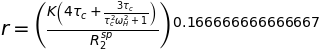

In [ ]:
r, K, tc, wh = symbols('r K τ_c ω_H')
Eq(r,((K/R2sp)*(4*tc + (3*tc/(1+wh**2*tc**2))))**(1/6))

#solve(Eq(r,((K/R2sp)*(4*tc + (3*tc/(1+wh**2*tc**2))))**(1/6)),R2sp)


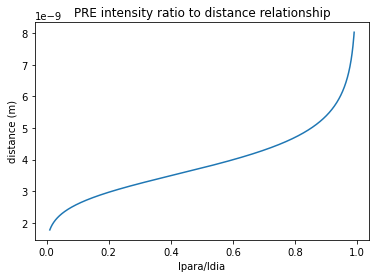

In [ ]:
# combining the two equations to get r from Ipara/Idia
from scipy.special import lambertw
from numpy import linspace
from math import *

# some constants
k = 1.23E-44  # m^6 s^-2
r2 = 0.15     # 1/Hz = s   # calculated from amide linewidth = pi/R2
T = 9.6E-3    # s          # total length of INEPT delays in HSQC
Tc = 8.0e-9   # s          # estimated from structure or from 15N relaxation
Wh = 599.98E6 # Hz = s^-1  # 1H frequency of spectrometer used
ulp = 0.0     # proportion unlabelled

def realLambertW(z):
  #takes a float, converts to complex, applies lambertw and returns real part
  compZ = complex(z,0)
  lwz = lambertw(compZ)
  #should check there's no complex part
  return lwz.real

def rFromIratio(Ir, r2, T, Tc, Wh, k=1.23E-44):
  # k = 1.23 x 10^-44 should be correct for m^6 s^-2 with no cm->m conversion
  #takes the intensity ratio and returns the coresponding distance
  Wbit = realLambertW((r2*T*exp(r2*T))/Ir)
  r = ((k/(-1*r2 + (Wbit/T)))*(4*Tc + (3*Tc/(1+Wh**2*Tc**2))))**(1/6)
  return r

# construct a calibration curve using the functions defined above
Iratio = linspace(ulp+0.01,0.99,1000)
distances = []
for Ir in Iratio:
  rIr = Ir-ulp
  r = rFromIratio(rIr, r2, T, Tc, Wh)
  distances.append(r)

# for drawing the graph
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("PRE intensity ratio to distance relationship")
plt.xlabel('Ipara/Idia')
plt.ylabel('distance (m)')
plt.plot(Iratio,distances)
#plt.legend()

## Analysis of experimental data
Compare distances calculated from Ipara/Idia intensity ratios with those measured from the structure(s).

In [113]:
import pandas as pd
import numpy as np

#Read Ipara/Idia ratios by residue number as a pandas dataframe
Irdf = pd.read_csv('MoRu21_Ir.csv')
Irdf = Irdf.rename(columns={"Residue": "resi", "Intensity Ratio":"Ir"})
Irdf = Irdf[['resi', 'Ir']]

# Read diamagnetic 1H linewidths by residue number as pandas dataframe.
# Calculate average linewidth for average R2 estimate or store per residue
# R2s to the Ipara/Idia dataframe for the distance extraction
lwdf = pd.read_csv('MoRu21_lw.csv', converters={"Assign F1": str})
lwdf = lwdf.assign(resi = lwdf["Assign F1"].str.extract("([0-9]+)"))
#convert resi to int dropping any NaNs
lwdf['resi']=lwdf['resi'].dropna().apply(np.int64)
lwdf = lwdf.assign(R2 = 2 * pi / lwdf["Line Width F1 (Hz)"])
r2df = lwdf[["resi","R2"]]

Irdf=Irdf.merge(right=r2df,on="resi")

#Add column to store distances and calculate using rFromIratio() 
Irdf['IrDist'] = Irdf.apply(lambda x: rFromIratio(x['Ir'], x['R2'], T, Tc, Wh), axis=1)

#Read distances of each amide H from the spin label attachment site as
# calculated from the structure(s) as a pandas dataframe
# string converter does not work on atom identifiers (probs with backticks & slashes?)
distdf = pd.read_csv('myDistances.csv', converters={"Atom Macro ID": str})
# so the str.extract() works peculiarly returning an object that can't be cast to an int
distdf = distdf.assign(resi = distdf["Atom Macro ID"].str.extract(r"`(.+)/H`"))
# so cast the object to a str first?
#distdf['resi']=distdf['resi'].apply(str)
#convert resi to int dropping any NaNs
distdf['resi']=distdf['resi'].dropna().apply(np.int64)

Irdf=Irdf.merge(right=distdf,on="resi")
Irdf=Irdf.rename(columns={" distance_to_origin": "strDist", "Atom Macro ID": "atomID"})
# convert to m for comparison with IrDist
Irdf['strDist'] = Irdf['strDist'] / 1.0e10

#Plot the PRE distances vs the structure distances and calculate correlation
# and stats by linear regression

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [114]:
Irdf

,resi,Ir,R2,IrDist,atomID,strDist
0,1,0.54011,0.375538,3.294146e-09,/2c34/A/A/MET`1/H`,2.576200e-09
1,2,0.46029,0.360379,3.145037e-09,/2c34/A/A/ILE`2/H`,2.566600e-09
2,3,0.26908,0.427228,2.661015e-09,/2c34/A/A/ALA`3/H`,2.369000e-09
3,15,1.00702,0.318057,NaN,/2c34/A/A/ASP`15/H`,2.011000e-09
4,16,0.96622,0.299240,5.821221e-09,/2c34/A/A/THR`16/H`,2.224800e-09
...,...,...,...,...,...,...
64,104,0.17373,0.367282,2.487718e-09,/2c34/A/A/GLU`104/H`,1.495100e-09
65,107,0.59365,0.277424,3.591736e-09,/2c34/A/A/THR`107/H`,1.387000e-09
66,108,0.82029,0.264803,4.375581e-09,/2c34/A/A/LEU`108/H`,1.418400e-09
67,111,1.00404,0.242254,NaN,/2c34/A/A/ASN`111/H`,2.131300e-09
